# 1. Community detection
Generate a random network with 200 nodes and three communities. Two communities should be sub-
stantially larger than the third one. For example, the first community can have 90 nodes, the second 70,
and the third one 40 nodes. To generate a strong community structure with more links within the groups
and less links between the groups you can use stochastic block model generator, e.g., SBM.

In [1]:
from IPython.display import Image

import numpy as np
import networkx as nx
from infomap import Infomap
from sklearn import metrics
from matplotlib import colormaps

In [2]:
n = 3
sizes = np.array([90, 70, 40])
probs = np.array([[0.817, 0.049, 0.041], [0.049, 0.784, 0.05], [0.041, 0.05, 0.808]])
probs


array([[0.817, 0.049, 0.041],
       [0.049, 0.784, 0.05 ],
       [0.041, 0.05 , 0.808]])

In [3]:
g = nx.stochastic_block_model(sizes, probs)

In [4]:
true_clusters = list(nx.get_node_attributes(g, 'block').values())

In [5]:
nx.set_node_attributes(g, [None] * 200, 'block')

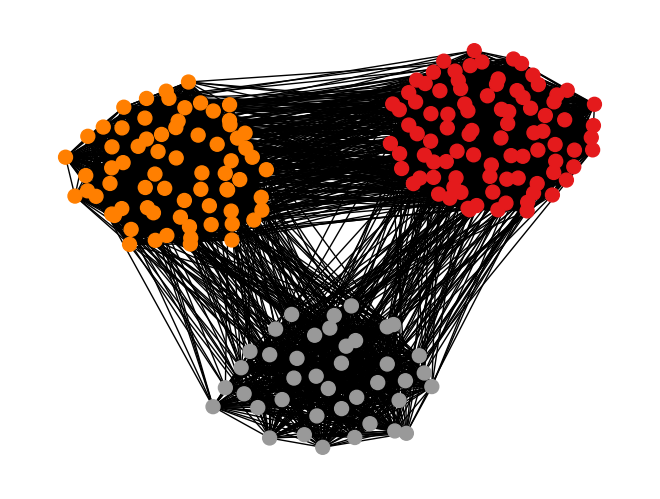

In [6]:
nx.draw(g, node_color=true_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

We will use a purity score for the evaluation of the clustering quality. The value is in range $[0, 1]$.

In [7]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

Using your generated network as the ground truth evaluate the following algorithms for community detection.

## Kernighan-Lin

In [8]:
def kernighan_lin_clustering(graph, n):
    subgraphs = [list(g.nodes)]
    while n > 1:
        nodes_to_split = subgraphs.pop(0)
        build_graph = graph.subgraph(nodes_to_split)
        clusters = nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(build_graph, max_iter=100, seed=42)
        subgraphs.append(list(clusters[0]))
        subgraphs.append(list(clusters[1]))
        n -= 1
    return subgraphs


In [9]:
kern_lin_clusters = kernighan_lin_clustering(g, 3)

In [10]:
def sort_clusters_in_nodes_order(clusters):
    node_comm_pairs = {
        node: idx
        for idx, cluster in enumerate(clusters)
        for node in cluster
    }
    result = dict(sorted(node_comm_pairs.items(), key=lambda x: x[0]))
    return list(result.values())

In [11]:
predicted_clusters = sort_clusters_in_nodes_order(kern_lin_clusters)

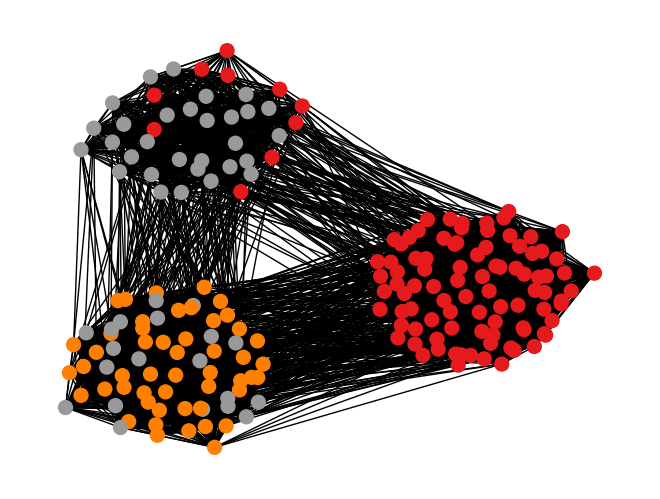

In [12]:
nx.draw(g, node_color=predicted_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [13]:
purity_score(true_clusters, predicted_clusters)

0.85

The problem of this method is bisecting into same size communities while ground truth clusters have different sizes. Also the problem is that we need to apply this method recursively so need to prioritize which subgraph to take first.

## Greed modularity maximization
We will use the Clauset-Newman-Moore greedy modularity maximization.

In [14]:
greedy_clusters = nx.algorithms.community.greedy_modularity_communities(g)

In [15]:
predicted_greedy_clusters = sort_clusters_in_nodes_order(greedy_clusters)

In [16]:
purity_score(true_clusters, predicted_greedy_clusters)

1.0

So, the Greedy modularity maximization method gives the exact result as True clusters are.

## Method on my choice
I hae chosen the InfoMap method for community detection.

In [17]:
im = Infomap("--two-level --silent")
mapping = im.add_networkx_graph(g)

In [18]:
im.run()

In [20]:
infomap_result = {
    node.physicalId: node.moduleIndex()
    for node in im.nodes
}
result = dict(sorted(infomap_result.items(), key=lambda x: x[0]))
infomap_pred_clusters = list(result.values())

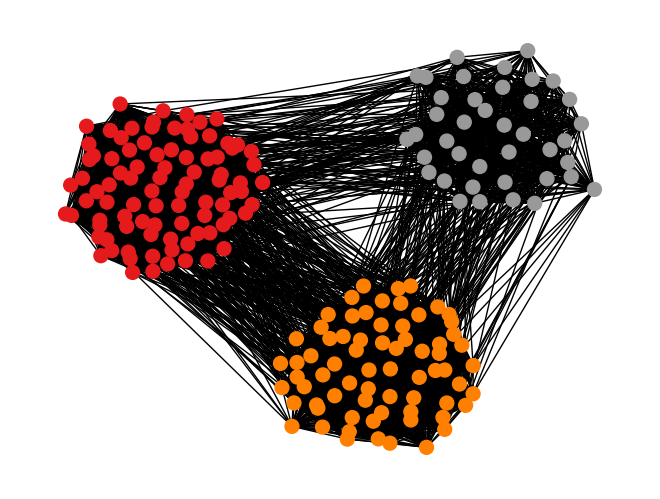

In [22]:
nx.draw(g, node_color=infomap_pred_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [23]:
purity_score(true_clusters, infomap_pred_clusters)

1.0

As we can see InfoMap algorithm can fully restore the community structure.